# Librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import random, shutil
import pathlib as pl
import os
from PIL import Image, ImageOps
from pathlib import Path
import zipfile
import hashlib
import traceback
tf.__version__

'2.19.0'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPU's: {len(gpus)}")

Available GPU's: 1


# Revision de Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/Yo/Proyecto2_m10/image_dataset_bangladeshi_currency_recognition.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [ ]:
# !pwd

/home/sergio_greda/maestria/Modulo_10/Proyecto2


In [5]:
!ls

'A Diverse Image Dataset for Bangladeshi Currency Recognition'	 sample_data
 drive


In [6]:
!mv 'A Diverse Image Dataset for Bangladeshi Currency Recognition' bangladeshi_currency_image_dataset

In [7]:
!cd bangladeshi_currency_image_dataset && ls -al

total 1789292
drwxr-xr-x 2 root root       4096 Aug 15 13:41 .
drwxr-xr-x 1 root root       4096 Aug 15 13:42 ..
-rw-r--r-- 1 root root 1832219269 Aug 15 13:42 Bangladeshi_Paper_Currency_Raw.zip


In [8]:
path = "bangladeshi_currency_image_dataset/Bangladeshi_Paper_Currency_Raw.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [9]:
!ls

bangladeshi_currency_image_dataset  drive
Bangladeshi_Paper_Currency_Raw	    sample_data


In [ ]:
# !cd Bangladeshi_Paper_Currency_Raw && ls

10  100  1000  2  20  200  5  50  500


In [5]:
basePath = Path("Bangladeshi_Paper_Currency_Raw")

classes = sorted([p.name for p in basePath.iterdir() if p.is_dir()])
classes

['10', '100', '1000', '2', '20', '200', '5', '50', '500']

In [6]:
SEED = 43

<br>

# Visualizacion de Datos

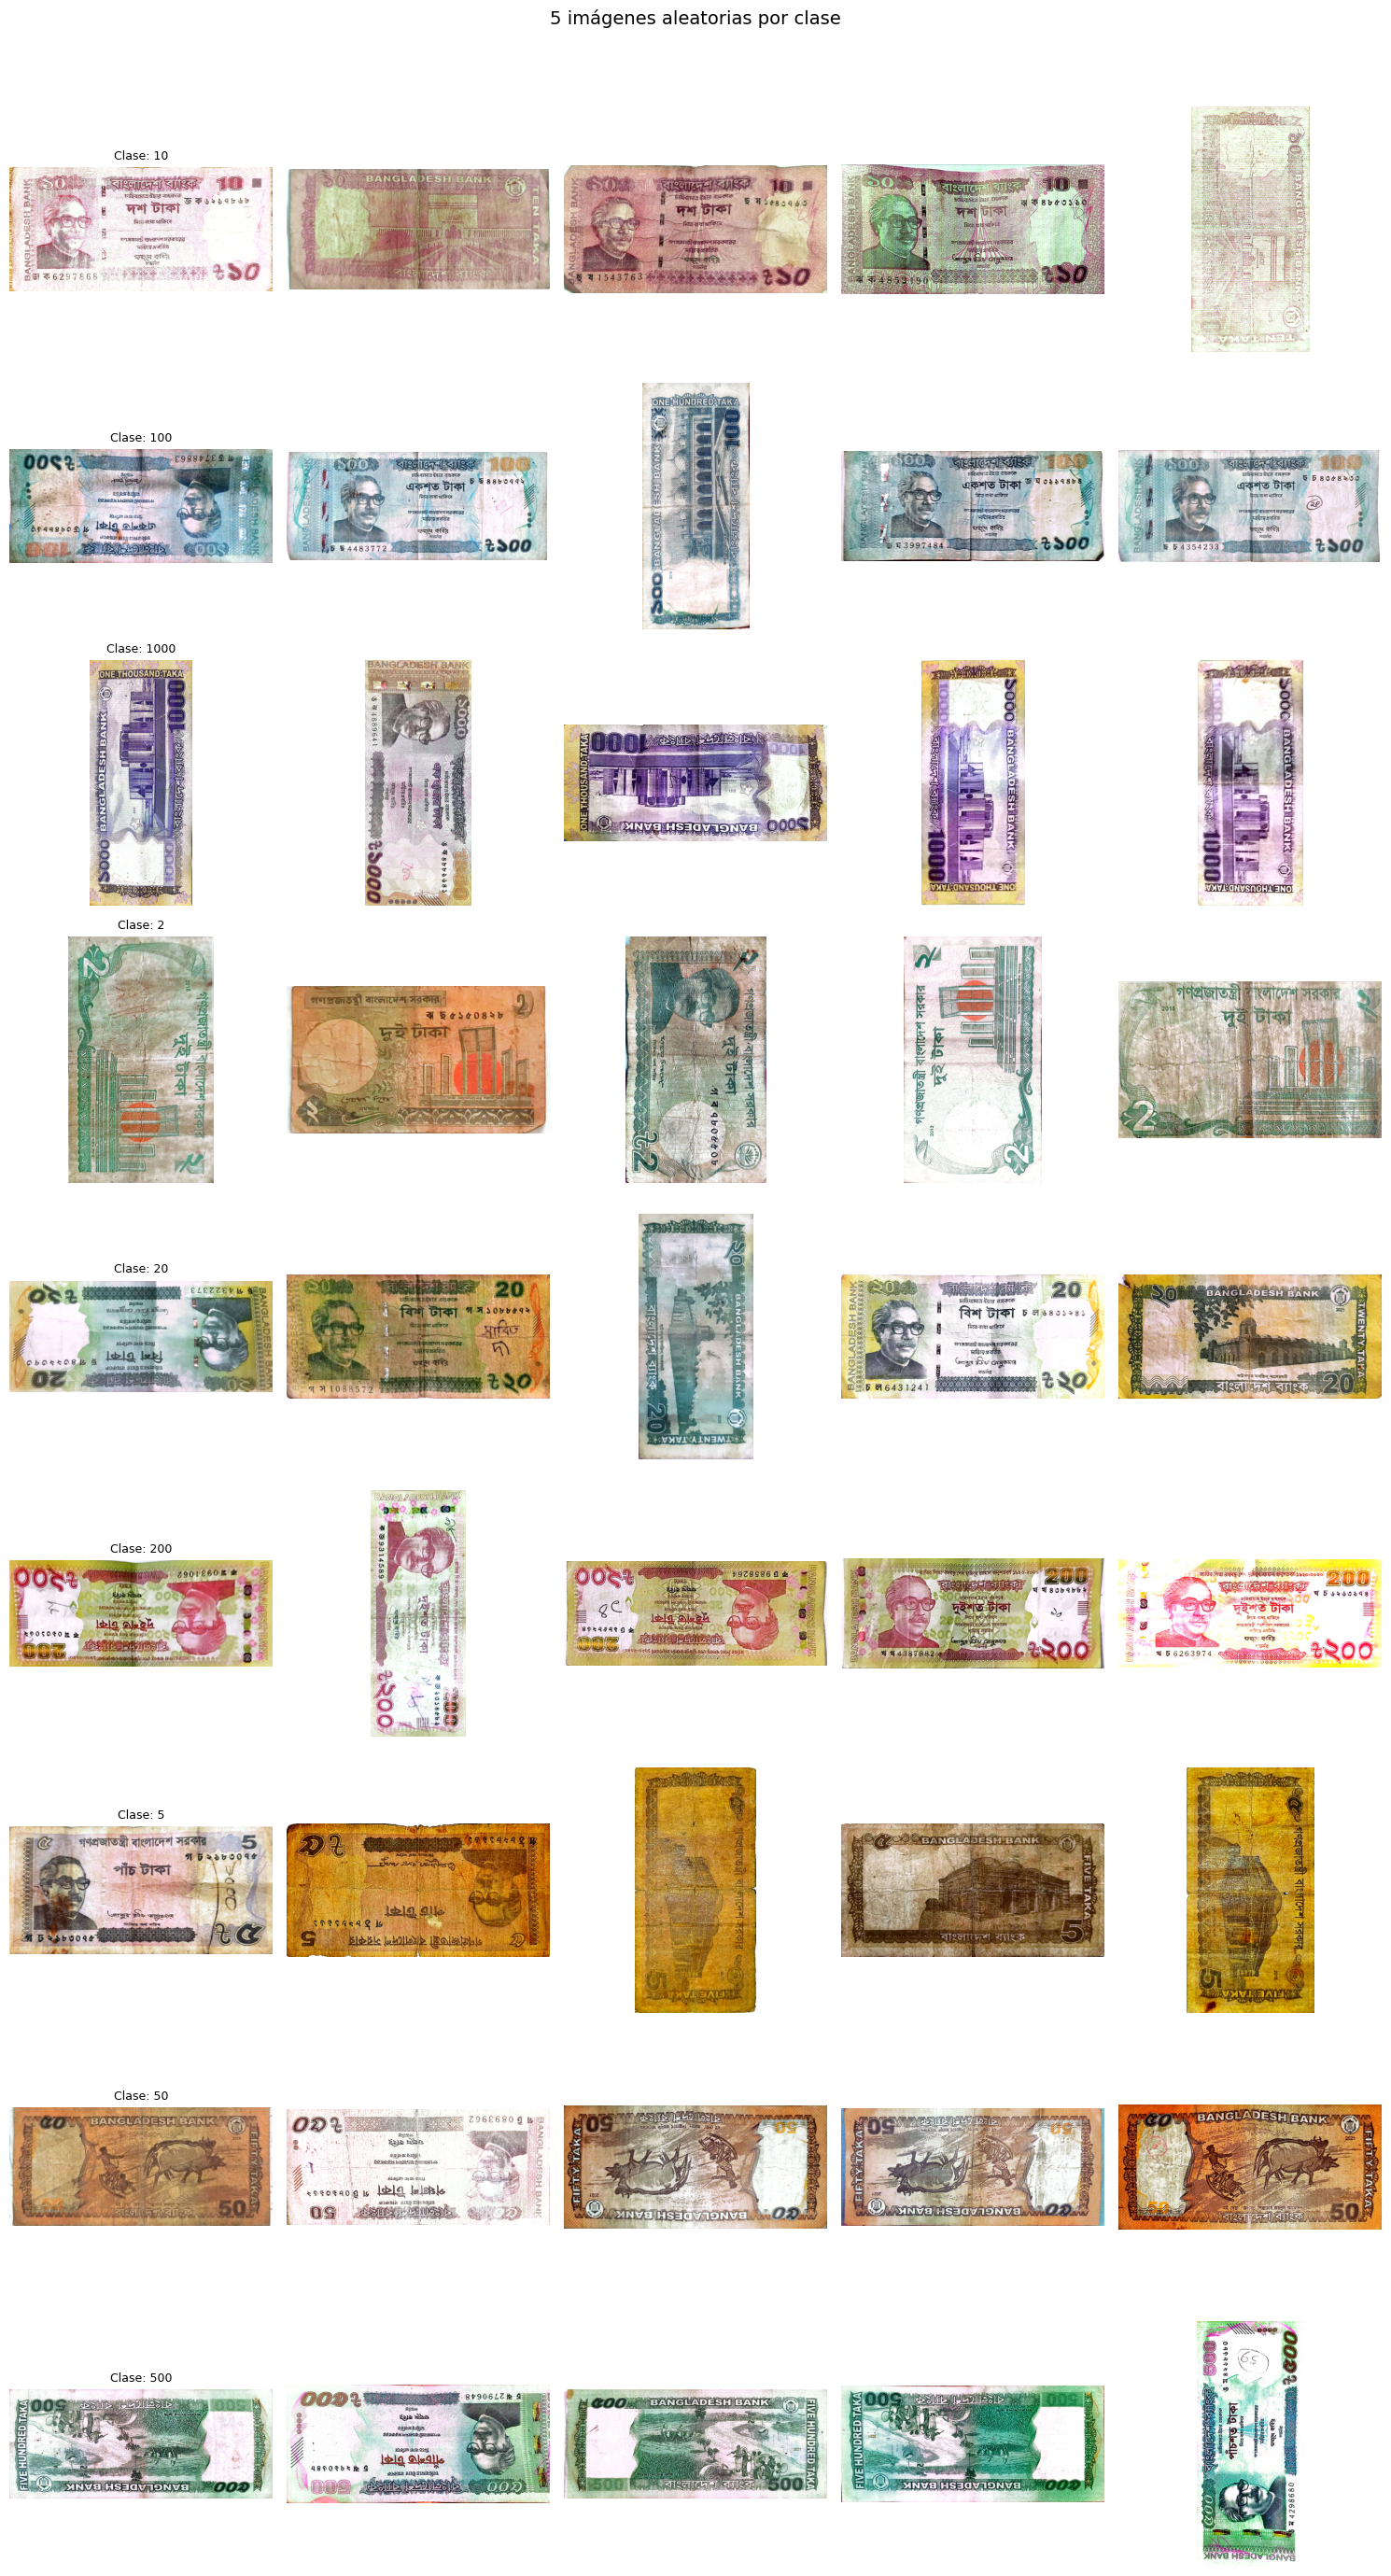

In [7]:
random.seed(SEED)
rows = len(classes)
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for r, cls in enumerate(classes):
    folder = Path(basePath) / cls
    files = [p for p in folder.glob("*") if p.is_file()]

    # if len(files) == 0:
    #     print(f"No hay imágenes en la clase {cls}")
    #     continue

    k = min(cols, len(files))
    sample_files = random.sample(files, k)

    for c in range(cols):
        ax = axes[r, c]
        ax.axis("off")
        if c < k:
            try:
                img = Image.open(sample_files[c]).convert("RGB")
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, "error", ha="center", va="center", fontsize=8)
        if c == 0:
            ax.set_title(f"Clase: {cls}", fontsize=9)

plt.suptitle("5 imágenes aleatorias por clase", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## Master Table

In [8]:
rows = []
for folder in sorted([p.name for p in basePath.iterdir() if p.is_dir()]):
    class_folder = basePath / folder
    for file in class_folder.glob('*'):
        if not file.is_file():
            continue
        try:
            with Image.open(file) as img:
                width, height = img.size
            size_bytes = file.stat().st_size
            rows.append({
                'rutaimagen': str(file),
                'nombreimagen': file.name,
                'etiqueta': folder,
                'ancho': width,
                'alto': height,
                'tamaño_bytes': size_bytes,
                'tamaño_mb': round(size_bytes / 1024**2, 3),
                'split_inicial': 'original',
                'error': None
            })
        except Exception as e:
            rows.append({
                'rutaimagen': str(file),
                'nombreimagen': file.name,
                'etiqueta': folder,
                'ancho': None,
                'alto': None,
                'tamaño_bytes': file.stat().st_size if file.exists() else None,
                'tamaño_mb': None,
                'split_inicial': 'original',
                'error': str(e)[:200]
            })

In [9]:
mt = pd.DataFrame(rows)
# mt.to_csv("master_table_pre_split.csv", index=False)

In [10]:
print("Master table:", mt.shape)

Master table: (5073, 9)


In [11]:
mt.head()

rutaimagen      nombreimagen  \
0  Bangladeshi_Paper_Currency_Raw/10/10  Taka_137...  10  Taka_137.jpg   
1  Bangladeshi_Paper_Currency_Raw/10/10  Taka_361...  10  Taka_361.jpg   
2  Bangladeshi_Paper_Currency_Raw/10/10  Taka_049...  10  Taka_049.jpg   
3  Bangladeshi_Paper_Currency_Raw/10/10  Taka_069...  10  Taka_069.jpg   
4  Bangladeshi_Paper_Currency_Raw/10/10  Taka_336...  10  Taka_336.jpg   

  etiqueta  ancho  alto  tamaño_bytes  tamaño_mb split_inicial error  
0       10   2340  1128       3205290      3.057      original  None  
1       10   1320  2788        597507      0.570      original  None  
2       10   2232  1056        368458      0.351      original  None  
3       10   2112  1016        363451      0.347      original  None  
4       10   1096  2240        582142      0.555      original  None

In [12]:
mt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5073 entries, 0 to 5072
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rutaimagen     5073 non-null   object 
 1   nombreimagen   5073 non-null   object 
 2   etiqueta       5073 non-null   object 
 3   ancho          5073 non-null   int64  
 4   alto           5073 non-null   int64  
 5   tamaño_bytes   5073 non-null   int64  
 6   tamaño_mb      5073 non-null   float64
 7   split_inicial  5073 non-null   object 
 8   error          0 non-null      object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.7 MB


In [13]:
mt['etiqueta'].unique()

array(['10', '100', '1000', '2', '20', '200', '5', '50', '500'],
      dtype=object)

In [14]:
mt['etiqueta'] = mt['etiqueta'].astype('category')

In [15]:
conteo = mt['etiqueta'].value_counts()
conteo

etiqueta
500     1243
5        660
100      565
20       480
2        445
200      423
1000     422
10       419
50       416
Name: count, dtype: int64

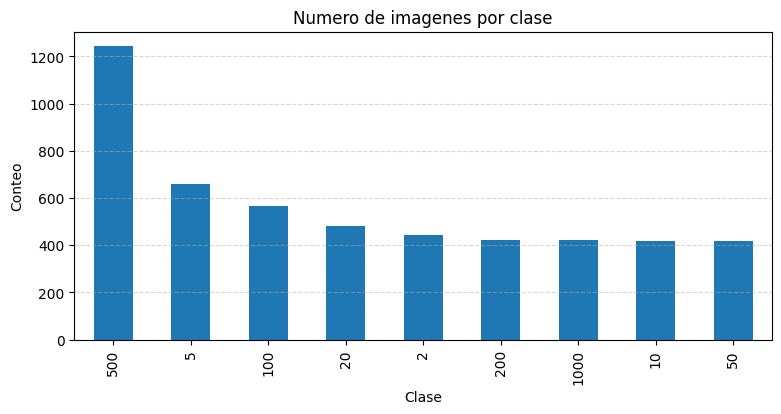

In [16]:
plt.figure(figsize=(9,4))
conteo.plot.bar(title="Numero de imagenes por clase")
plt.xlabel("Clase")
plt.ylabel("Conteo")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [17]:
mt.describe()

ancho         alto  tamaño_bytes    tamaño_mb
count  5073.000000  5073.000000  5.073000e+03  5073.000000
mean   2002.744530  1373.394244  3.615804e+05     0.344834
std     853.648813   672.977877  2.595394e+05     0.247519
min     424.000000   400.000000  2.913200e+04     0.028000
25%    1292.000000   856.000000  2.114060e+05     0.202000
50%    1872.000000  1286.000000  3.055580e+05     0.291000
75%    3000.000000  1512.000000  4.626940e+05     0.441000
max    3356.000000  3592.000000  3.306173e+06     3.153000

In [18]:
total_mb = mt['tamaño_mb'].sum()
print(f"Tamaño total de dataset: {total_mb:.2f} MB")

Tamaño total de dataset: 1749.34 MB


In [19]:
errores = mt[mt['error'].notnull()]
if not errores.empty:
    print("Imagenes con error de lectura:", len(errores))
    display(errores.head())
else:
    print("No hay errores de lectura.")

No hay errores de lectura.


# Preprocesamiento de datos

## Copia de Trabajo para Splits

In [20]:
og_base = basePath
curated_base = Path("Bangladeshi_Paper_Currency_Curated")
curated_base.mkdir(parents=True, exist_ok=True)

In [21]:
if curated_base.exists() and any(curated_base.iterdir()):
    print(f"La base de trabajo {curated_base}, ya existe")
else:
    for class_dir in [p for p in og_base.iterdir() if p.is_dir()]:
        class_name = class_dir.name
        dest_class_dir = curated_base / class_name
        dest_class_dir.mkdir(parents=True, exist_ok=True)

        all_files_in_class_dir = [p for p in class_dir.glob("*") if p.is_file()]

        for img in all_files_in_class_dir:
            shutil.copy2(str(img), str(dest_class_dir / img.name))
        print(f"Clase {class_name}: {len(all_files_in_class_dir)} archivos copiados.")

La base de trabajo Bangladeshi_Paper_Currency_Curated, ya existe


## Actualizando Master Table

In [27]:
rows = []
for folder in sorted([p for p in curated_base.iterdir() if p.is_dir()]):
    for file in folder.glob('*'):
        if not file.is_file():
            continue
        try:
            with Image.open(file) as img:
                width, height = img.size
            size_bytes = file.stat().st_size
            rows.append({
                'rutaimagen': str(file.resolve()),
                'nombreimagen': file.name,
                'etiqueta': folder.name,
                'ancho': width,
                'alto': height,
                'tamaño_bytes': size_bytes,
                'tamaño_mb': round(size_bytes / 1024**2, 4),
                'split_inicial': 'curated',
                'error': None
            })
        except Exception as e:
            rows.append({
                'rutaimagen': str(file.resolve()),
                'nombreimagen': file.name,
                'etiqueta': folder.name,
                'ancho': None,
                'alto': None,
                'tamaño_bytes': file.stat().st_size if file.exists() else None,
                'tamaño_mb': None,
                'split_inicial': 'curated',
                'error': str(e)[:200]
            })

In [28]:
mt_curated = pd.DataFrame(rows)
# mt_curated.to_csv("master_table_curated.csv", index=False)
print("master_table_curated Conteo de clases:\n", mt_curated['etiqueta'].value_counts())

master_table_curated Conteo de clases:
 etiqueta
500     1243
5        660
100      565
20       480
2        445
200      423
1000     422
10       419
50       416
Name: count, dtype: int64


In [29]:
mt_curated.head()

rutaimagen      nombreimagen  \
0  /content/Bangladeshi_Paper_Currency_Curated/10...  10  Taka_137.jpg   
1  /content/Bangladeshi_Paper_Currency_Curated/10...  10  Taka_361.jpg   
2  /content/Bangladeshi_Paper_Currency_Curated/10...  10  Taka_049.jpg   
3  /content/Bangladeshi_Paper_Currency_Curated/10...  10  Taka_069.jpg   
4  /content/Bangladeshi_Paper_Currency_Curated/10...  10  Taka_336.jpg   

  etiqueta  ancho  alto  tamaño_bytes  tamaño_mb split_inicial error  
0       10   2340  1128       3205290     3.0568       curated  None  
1       10   1320  2788        597507     0.5698       curated  None  
2       10   2232  1056        368458     0.3514       curated  None  
3       10   2112  1016        363451     0.3466       curated  None  
4       10   1096  2240        582142     0.5552       curated  None

## Creacion de trainvalSplits folders (folders para entrenamiento y validacion)

In [22]:
newDest = curated_base / "trainvalSplits"

In [23]:
if newDest.exists() and any(newDest.iterdir()):
    print("trainvalSplits ya existe")
else:
    for c in classes:
        cPath = Path(os.path.join(curated_base, c))
        filesIncPath = list(cPath.glob("*"))

        newcFolderPath = newDest / cPath.name
        newcFolderPath.mkdir(parents=True, exist_ok=True)

        for file in filesIncPath:
            targetFile = newcFolderPath / file.name
            if not targetFile.exists():
                shutil.move(str(file),str(targetFile))
        if not any(cPath.iterdir()):
            cPath.rmdir()

trainvalSplits ya existe


In [24]:
x = sorted([p.name for p in curated_base.iterdir() if p.is_dir()])
x

['testSplit', 'trainvalSplits']

## Creacion del testSplits folder (folder de testeo)

In [25]:
test_root = curated_base / "testSplit"

In [24]:
random.seed(SEED)

In [26]:
if test_root.exists() and any(test_root.iterdir()):
    print("testSplit ya existe")
else:
    for c in classes:
        classPath = newDest / c
        files = list(classPath.glob("*"))

        k = max(1, int(len(files)*0.10))
        test_filestemp = random.sample(files, k)

        dest_dir = test_root / classPath.name
        dest_dir.mkdir(parents=True, exist_ok=True)

        for f in test_filestemp:

            target = dest_dir/f.name
            if not target.exists():
                shutil.move(str(f), str(target))

        print(f"Ahora en carptea {newDest.name} clase {c}: {len(list(classPath.glob('*')))} archivos")
        print(f"En nueva carpet the testeo {test_root.name} clase {c}: {len(list(dest_dir.glob('*')))} archivos")

testSplit ya existe


In [27]:
x = [c.name for c in curated_base.iterdir() if c.is_dir()]
x

['testSplit', 'trainvalSplits']

## Distribucion de clases en trainvalSplit

In [28]:
conteo_trainval = {c.name: len(list((newDest / c.name).glob('*'))) for c in newDest.iterdir() if c.is_dir()}
conteo_trainval = pd.Series(conteo_trainval).sort_index()
print("Distribucion de clases en trainvalSplit:\n", conteo_trainval)

Distribucion de clases en trainvalSplit:
 10       378
100      509
1000     380
2        401
20       432
200      381
5        594
50       375
500     1119
dtype: int64


In [29]:
conteo_test = {p.name: len(list((test_root / p.name).glob('*'))) for p in test_root.iterdir() if p.is_dir()}
conteo_test = pd.Series(conteo_test).sort_index()
print("\nDistribucion de clases en testSplit:\n", conteo_test)


Distribucion de clases en testSplit:
 10       41
100      56
1000     42
2        44
20       48
200      42
5        66
50       41
500     124
dtype: int64


## Validacion para la reduccion de tamaño de imagenes

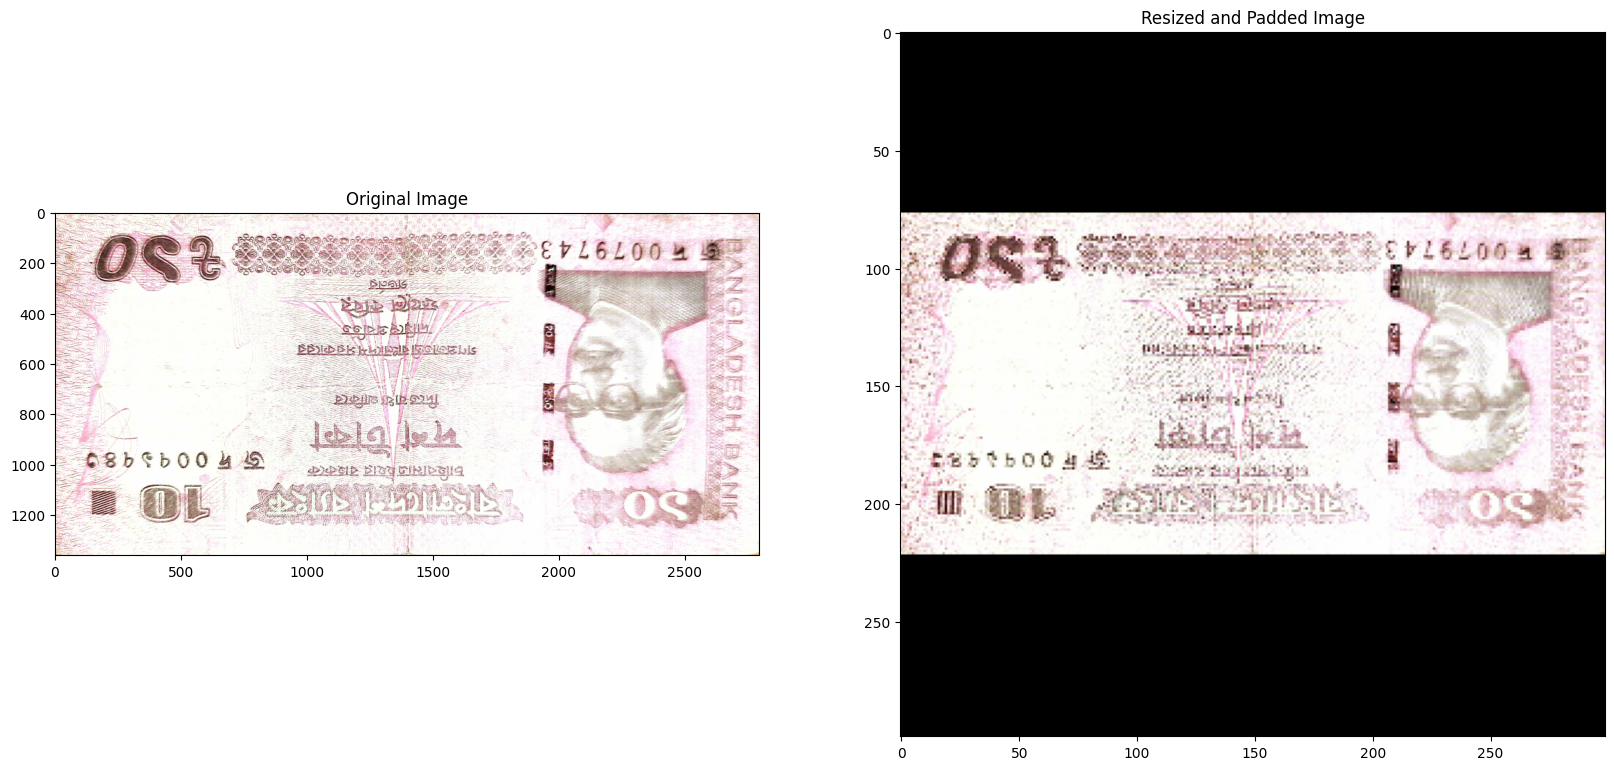

In [30]:
folder = "10"
imagesPath = Path(os.path.join(newDest, folder))
pathList = list(imagesPath.glob("*"))
randomImagePath = random.choice(pathList)


raw_image = tf.io.read_file(str(randomImagePath))
og_image = tf.image.decode_jpeg(raw_image, channels=3)
ogImageTf = tf.cast(og_image, tf.float32)
resize_layer = tf.keras.layers.Resizing(height=299,width=299, pad_to_aspect_ratio=True)
resizedImage = resize_layer(ogImageTf)


plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(og_image.numpy().astype("uint8"))
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(resizedImage.numpy().astype("uint8"))
plt.title("Resized and Padded Image")

plt.show()

# Preparacion de datos

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

In [32]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [33]:
trainval_root = newDest
image_size = (299, 299)
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

In [34]:
class_names = sorted([p.name for p in trainval_root.iterdir() if p.is_dir()])
class_to_index = {n: i for i, n in enumerate(class_names)}

X_paths = []
y_index = []
for clas in class_names:
    patc = trainval_root / clas
    files = sorted([str(fp) for fp in patc.glob('*') if fp.is_file()])
    X_paths.extend(files)
    y_index.extend([class_to_index[clas]] * len(files))

In [35]:
X_paths = np.array(X_paths, dtype=str)
y_index = np.array(y_index, dtype=np.int32)

print("Total imagenes en trainvalSplits:", len(X_paths))
for i, name in enumerate(class_names):
    print(i, name, "->", np.sum(y_index == i))

Total imagenes en trainvalSplits: 4569
0 10 -> 378
1 100 -> 509
2 1000 -> 380
3 2 -> 401
4 20 -> 432
5 200 -> 381
6 5 -> 594
7 50 -> 375
8 500 -> 1119


## Normalizacion, cambio de tamaño de imagenes y aumento de datos

## Train Val Splits

#### Noramlizacion y cambio de tamaño

In [36]:
resize_layer = tf.keras.layers.Resizing(image_size[0], image_size[1], pad_to_aspect_ratio=True, interpolation='bilinear')
num_classes = len(class_names)

In [37]:
def load_and_preprocess_tf(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = resize_layer(img)
    img = img / 255.0
    label = tf.cast(label, tf.int32)
    return img, label

#### Aumento de datos (augmenting)

In [38]:
augment = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal"),
    # tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomZoom(0.10,),
    # tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomContrast(0.2),
])

def make_dataset_from_paths(paths, labels, batch=batch_size, shuffle=False, augment_on=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(paths), seed=SEED)
    dataset = dataset.map(load_and_preprocess_tf, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch)
    if augment_on:
        dataset = dataset.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## Test Split

### Cambio de tamaño de imagenes

In [39]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling

In [40]:
raw_testSplit = image_dataset_from_directory(
    test_root,
    shuffle=False,
    image_size=(299, 299),
    batch_size=batch_size,
    pad_to_aspect_ratio=True,
    label_mode="int",
)

Found 504 files belonging to 9 classes.


#### Normalizacion

In [41]:
scaling_layer = Rescaling(1./255)

def preprocess(image, label):
    image = scaling_layer(image)
    return image, label

testSplit = raw_testSplit.map(preprocess)

# 5-fold CV, Creacion del modelo y entrenamiento

## Creacion del Modelo

In [42]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

In [43]:
def build_model():
    model = Sequential([
        Input(shape=(299, 299, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'), # Filtro 32 de 3x3 con activacion relu para imagenes de 299X299
        # Salida: 299, 299, 32
        MaxPooling2D(pool_size=(2,2)),
        # Salida: 149, 149, 32
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        # Salida: 149, 149, 64
        MaxPooling2D(pool_size=(2, 2)),
        # Salida: 74, 74, 64)
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        # Salida: 74, 74, 64
        MaxPooling2D(pool_size=(2,2)),
        # Salida: 37, 37, 64
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        # Salida: 37, 37, 128
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        # Salida: 37, 37, 256
        # cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])
    return model

In [44]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,873 (2.03 MB)

 Trainable params: 532,873 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

## 5-fold CV y entrenamiento del mdoelo

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [46]:
EPOCHS = 60
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

In [47]:
folds = list(skf.split(X_paths, y_index))
print(n_splits, "folds preparados (train/val index pairs).")

5 folds preparados (train/val index pairs).


In [48]:
histories = []
model_paths = []

for fold_index, (train_index, val_index) in enumerate(folds):
    print("\n=== Fold", fold_index+1, "===")
    X_train_paths = X_paths[train_index]
    y_train = y_index[train_index]
    X_val_paths = X_paths[val_index]
    y_val = y_index[val_index]

    unique, counts = np.unique(y_train, return_counts=True)
    print("Train counts:", dict(zip(unique, counts)))

    classes = np.arange(num_classes)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weight_for_keras = {int(clas): float(weight) for clas, weight in zip(classes, cw)}
    print("class_weight:", class_weight_for_keras)

    trainSplit = make_dataset_from_paths(X_train_paths, y_train, batch=batch_size,
                                       shuffle=True, augment_on=True)   # augment_on=True only for train
    valSplit   = make_dataset_from_paths(X_val_paths,   y_val,   batch=batch_size,
                                       shuffle=False, augment_on=False)


    model_path = f"best_cnn_fold{fold_index+1}.keras"
    chckpnt  = ModelCheckpoint(f"best_cnn_fold{fold_index+1}.keras", save_best_only=True)
    early = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
    reducerLr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)

    model = build_model()

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer='Adam',
        metrics=['accuracy']
    )

    history = model.fit(
        trainSplit,
        validation_data=valSplit,
        epochs=EPOCHS,
        callbacks=[early, chckpnt, reducerLr],  # define callbacks as needed
        class_weight=class_weight_for_keras
    )
    histories.append(history.history)
    model_paths.append(model_path)


=== Fold 1 ===
Train counts: {np.int32(0): np.int64(302), np.int32(1): np.int64(407), np.int32(2): np.int64(304), np.int32(3): np.int64(321), np.int32(4): np.int64(346), np.int32(5): np.int64(304), np.int32(6): np.int64(476), np.int32(7): np.int64(300), np.int32(8): np.int64(895)}
class_weight: {0: 1.344738778513613, 1: 0.9978159978159978, 2: 1.335891812865497, 3: 1.2651436483212184, 4: 1.1737315350032114, 5: 1.335891812865497, 6: 0.8531746031746031, 7: 1.3537037037037036, 8: 0.4537554314090627}
Epoch 1/60
229/229 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.1629 - loss: 2.1515 - val_accuracy: 0.2921 - val_loss: 1.6359 - learning_rate: 0.0010
Epoch 2/60
229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.3109 - loss: 1.7292 - val_accuracy: 0.3370 - val_loss: 1.6602 - learning_rate: 0.0010
Epoch 3/60
229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.4363 - loss: 1.5449 - val_accuracy: 0.4530 - val_loss: 1.2912 - learning_rate: 0.0010
Epoch 4/60
229/229 ━━━━━━━━━━━━━━

<br>
<br>


<br>

# Validacion del Modelo

In [49]:
def _extract_history(h):

    if hasattr(h, "history"):
        return h.history
    if isinstance(h, dict) and "history" in h:
        return h["history"]
    return h

def plot_per_fold(histories, save=False, save_dir=".", show=True):

    for i, h_raw in enumerate(histories):
        h = _extract_history(h_raw)

        train_acc = h.get("accuracy") or h.get("acc")
        val_acc   = h.get("val_accuracy") or h.get("val_acc")
        train_loss = h.get("loss")
        val_loss   = h.get("val_loss")

        fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"Fold {i+1} — metricas train / val", fontsize=14)

        # Accuracy plot
        if train_acc is not None or val_acc is not None:
            if train_acc is not None:
                ax_acc.plot(range(1, len(train_acc)+1), train_acc,
                            label="train accuracy", linestyle='-', alpha=0.8)
            if val_acc is not None:
                ax_acc.plot(range(1, len(val_acc)+1), val_acc,
                            label="val accuracy", linestyle='--', alpha=0.9)
            ax_acc.set_xlabel("Epoch")
            ax_acc.set_ylabel("Accuracy")
            ax_acc.set_title("Accuracy")
            ax_acc.grid(True, linestyle=':', linewidth=0.6)
            ax_acc.legend()
        else:
            ax_acc.text(0.5, 0.5, "No accuracy data", ha='center', va='center')
            ax_acc.axis('off')

        # Loss plot
        if train_loss is not None or val_loss is not None:
            if train_loss is not None:
                ax_loss.plot(range(1, len(train_loss)+1), train_loss,
                             label="train loss", linestyle='-', alpha=0.8)
            if val_loss is not None:
                ax_loss.plot(range(1, len(val_loss)+1), val_loss,
                             label="val loss", linestyle='--', alpha=0.9)
            ax_loss.set_xlabel("Epoch")
            ax_loss.set_ylabel("Loss")
            ax_loss.set_title("Loss")
            ax_loss.grid(True, linestyle=':', linewidth=0.6)
            ax_loss.legend()
        else:
            ax_loss.text(0.5, 0.5, "No loss data", ha='center', va='center')
            ax_loss.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save:
            fname = f"{save_dir}/fold_{i+1}_metrics.png"
            fig.savefig(fname, dpi=150, bbox_inches="tight")
            print(f"Saved {fname}")

        if show:
            plt.show()
        else:
            plt.close(fig)


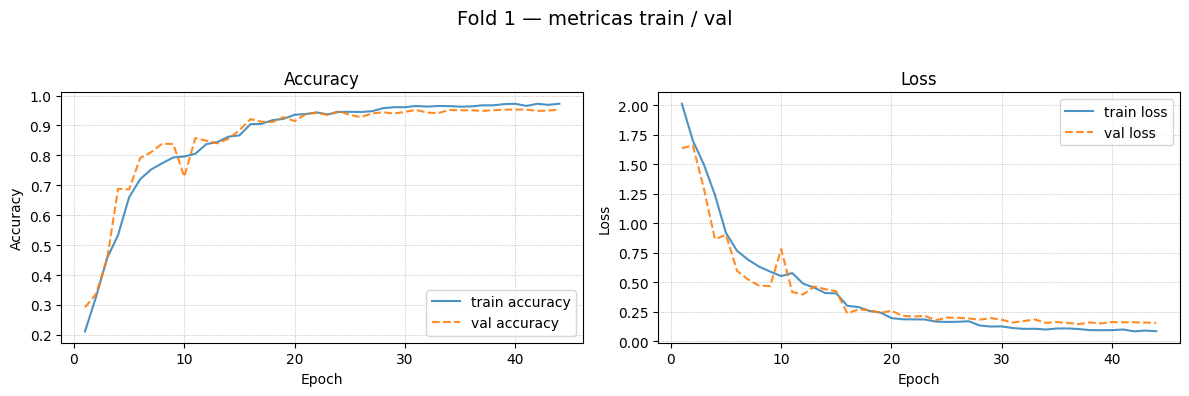

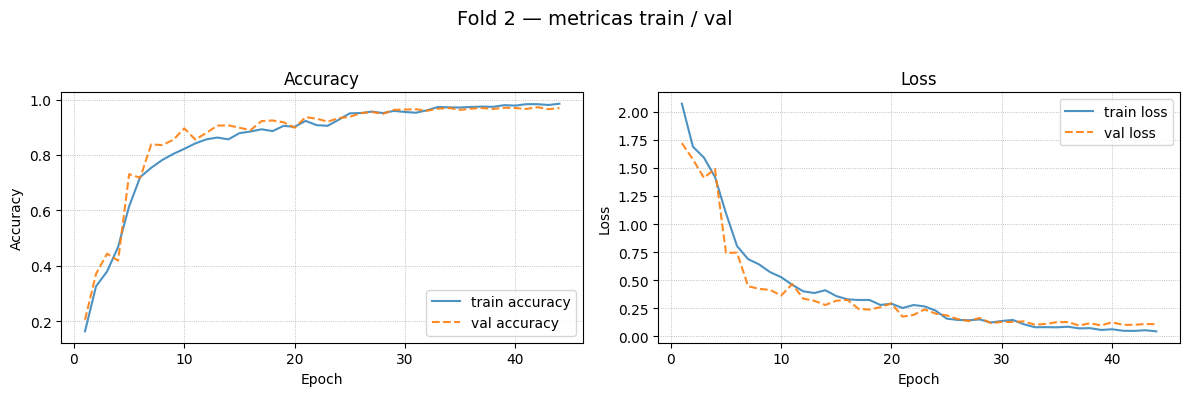

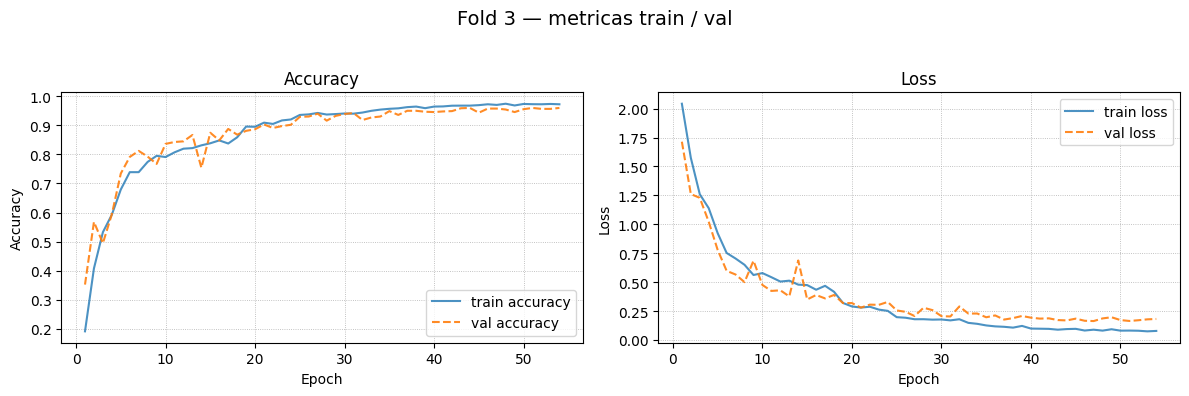

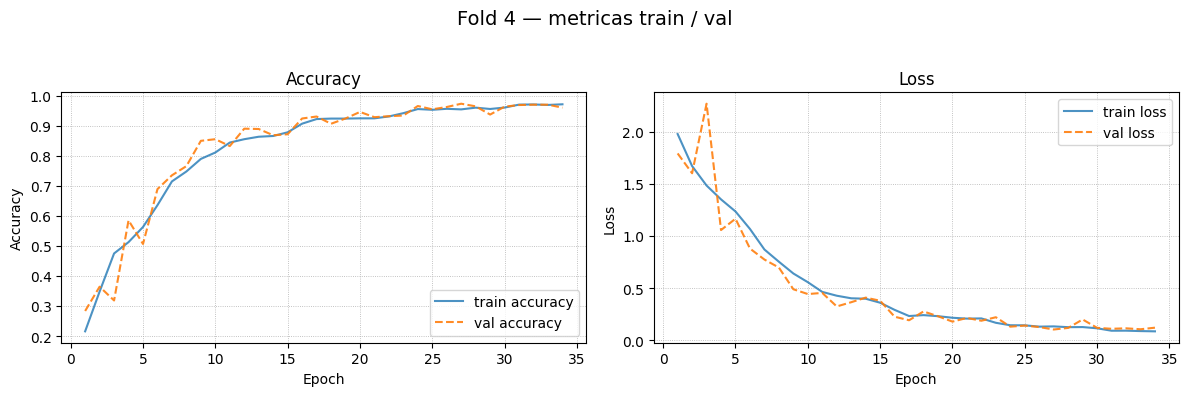

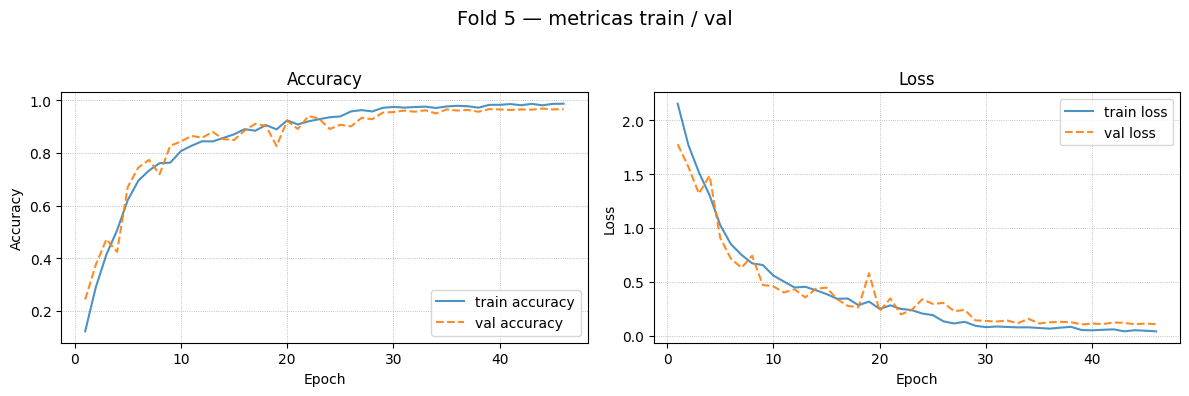

In [50]:
plot_per_fold(histories, save=False, show=True)

In [68]:
accs = []
val_accs = []
losses = []
val_losses = []

for h in histories:
    accs.append(h['accuracy'])
    val_accs.append(h['val_accuracy'])
    losses.append(h['loss'])
    val_losses.append(h['val_loss'])

In [69]:
max_epochs = max(map(len, accs))

def pad_and_stack(list_of_lists):
    stacked = []
    for lst in list_of_lists:
        if len(lst) < max_epochs:
            stacked.append(np.concatenate([lst, np.full(max_epochs-len(lst), lst[-1])]))
        else:
            stacked.append(np.array(lst[:max_epochs]))
    return np.vstack(stacked)

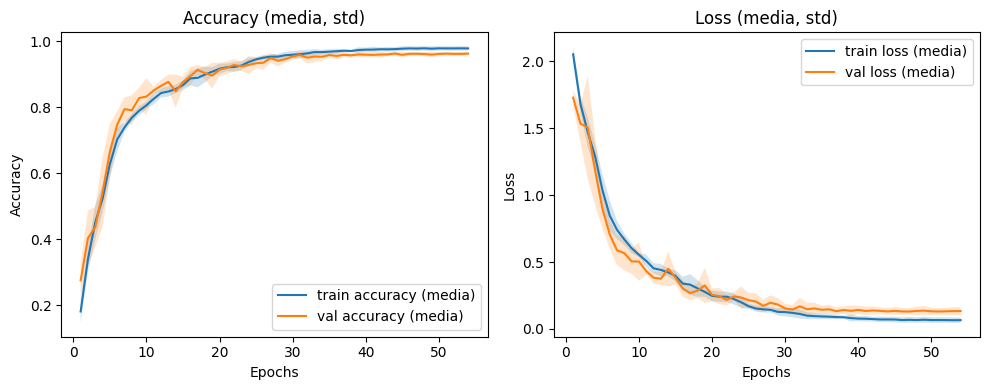

In [71]:
accs_arr = pad_and_stack(accs)
val_accs_arr = pad_and_stack(val_accs)
losses_arr = pad_and_stack(losses)
val_losses_arr = pad_and_stack(val_losses)

# Accuracy
epochs = np.arange(1, max_epochs+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
mean_acc = accs_arr.mean(axis=0); std_acc = accs_arr.std(axis=0)
plt.plot(epochs, mean_acc, label='train accuracy (media)')
plt.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, alpha=0.2)
mean_val_acc = val_accs_arr.mean(axis=0); std_val_acc = val_accs_arr.std(axis=0)
plt.plot(epochs, mean_val_acc, label='val accuracy (media)')
plt.fill_between(epochs, mean_val_acc-std_val_acc, mean_val_acc+std_val_acc, alpha=0.2)
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy (media, std)')

# Loss
plt.subplot(1,2,2)
mean_loss = losses_arr.mean(axis=0); std_loss = losses_arr.std(axis=0)
plt.plot(epochs, mean_loss, label='train loss (media)')
plt.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, alpha=0.2)
mean_val_loss = val_losses_arr.mean(axis=0); std_val_loss = val_losses_arr.std(axis=0)
plt.plot(epochs, mean_val_loss, label='val loss (media)')
plt.fill_between(epochs, mean_val_loss-std_val_loss, mean_val_loss+std_val_loss, alpha=0.2)
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss (media, std)')
plt.tight_layout()
plt.show()


<br>

# Reporte OOF (trainvalSplits)

In [58]:
from sklearn.metrics import precision_recall_fscore_support

Procesando fold 1
Procesando fold 2
Procesando fold 3
Procesando fold 4
Procesando fold 5

=== Reporte de clasificacion agregada OOF ===

              precision    recall  f1-score   support

          10     0.9214    0.8995    0.9103       378
         100     0.9786    0.9862    0.9824       509
        1000     0.9691    0.9895    0.9792       380
           2     0.9924    0.9776    0.9849       401
          20     0.9742    0.9630    0.9686       432
         200     0.9895    0.9895    0.9895       381
           5     0.9321    0.9478    0.9399       594
          50     0.8875    0.9253    0.9060       375
         500     0.9873    0.9714    0.9793      1119

    accuracy                         0.9630      4569
   macro avg     0.9591    0.9611    0.9600      4569
weighted avg     0.9634    0.9630    0.9631      4569



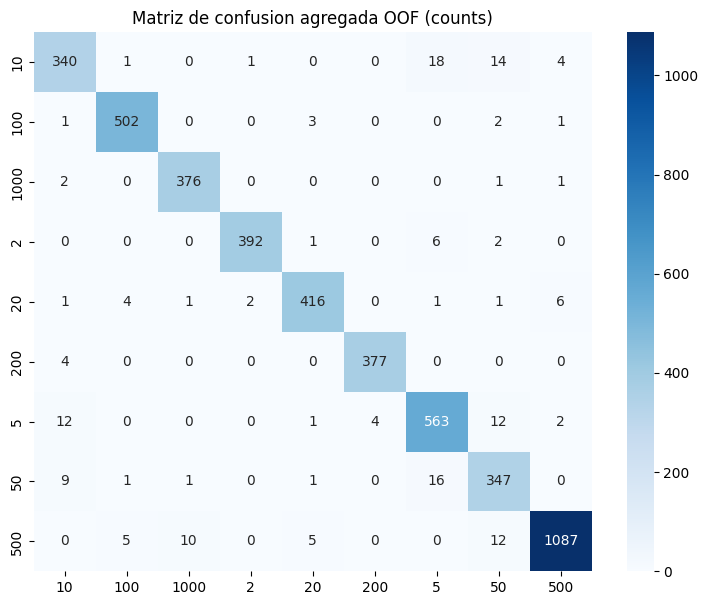

class  precision    recall        f1  support
0    10   0.921409  0.899471  0.910308      378
1   100   0.978558  0.986248  0.982387      509
2  1000   0.969072  0.989474  0.979167      380
3     2   0.992405  0.977556  0.984925      401
4    20   0.974239  0.962963  0.968568      432
5   200   0.989501  0.989501  0.989501      381
6     5   0.932119  0.947811  0.939900      594
7    50   0.887468  0.925333  0.906005      375
8   500   0.987284  0.971403  0.979279     1119

In [60]:
all_true = []
all_pred = []

for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f"Procesando fold {fold_idx+1}")
    model = tf.keras.models.load_model(model_paths[fold_idx], compile=False)
    X_val = X_paths[val_idx]
    y_val = y_index[val_idx]
    val_ds = make_dataset_from_paths(X_val, y_val, batch=batch_size, shuffle=False, augment_on=False)
    probs = model.predict(val_ds, verbose=0)
    preds = np.argmax(probs, axis=1)[:len(y_val)]
    all_true.append(y_val)
    all_pred.append(preds)

y_true_oof = np.concatenate(all_true)
y_pred_oof = np.concatenate(all_pred)

print("\n=== Reporte de clasificacion agregada OOF ===\n")
print(classification_report(y_true_oof, y_pred_oof, target_names=class_names, digits=4))

cm_oof = confusion_matrix(y_true_oof, y_pred_oof)
plt.figure(figsize=(9,7))
sns.heatmap(cm_oof, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Matriz de confusion agregada OOF (counts)')
plt.show()


p, r, f, s = precision_recall_fscore_support(y_true_oof, y_pred_oof, labels=range(len(class_names)))
df_oof = pd.DataFrame({'class': class_names, 'precision': p, 'recall': r, 'f1': f, 'support': s})
display(df_oof)


## Matriz de confusion y reporte de classifacion conjunto (testSplits)

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

In [63]:
n_folds = 5
model_files = [f"best_cnn_fold{i+1}.keras" for i in range(n_folds)]
model_files = [m for m in model_files if os.path.exists(m)]
print("Modelos Guardados:", model_files)

Modelos Guardados: ['best_cnn_fold1.keras', 'best_cnn_fold2.keras', 'best_cnn_fold3.keras', 'best_cnn_fold4.keras', 'best_cnn_fold5.keras']


In [64]:
y_test = np.concatenate([y.numpy() for _, y in testSplit], axis=0)
print("Imagenes (etiquetas) in y_pred:", len(y_test))

Imagenes (etiquetas) in y_pred: 504


In [65]:
test_file_paths = []

for class_dir in [p for p in test_root.iterdir() if p.is_dir()]:
    files = [str(filepath) for filepath in (test_root / class_dir.name).glob('*') if filepath.is_file()]
    test_file_paths.extend(files)

test_file_paths = np.array(test_file_paths)
print("Numero de imagenes en testSplit:", len(test_file_paths))
assert len(test_file_paths) == len(y_test), "Number of file paths and labels must match."

Numero de imagenes en testSplit: 504


In [66]:
all_cms = []
ensemble_logits = None

for modelfile in model_files:
    print("\n=== Evaluando", modelfile, "===\n")
    model = load_model(modelfile)
    # evaluate (loss, acc)
    res = model.evaluate(testSplit, verbose=1)
    print("evaluacion ->", res)
    # predict probabilities over the whole test dataset
    probs = model.predict(testSplit, verbose=0)   # shape (n_test, num_classes)
    preds = np.argmax(probs, axis=1)
    # metrics
    cm = confusion_matrix(y_test, preds)
    print("Confusion matrix (counts):\n", cm)
    print("\nClassification report:\n", classification_report(y_test, preds, target_names=class_names, digits=4))
    all_cms.append((modelfile, cm))

    if ensemble_logits is None:
        ensemble_logits = probs.copy()
    else:
        ensemble_logits += probs


=== Evaluando best_cnn_fold1.keras ===

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9374 - loss: 0.1955
evaluacion -> [0.1751689463853836, 0.954365074634552]
Confusion matrix (counts):
 [[ 33   0   0   0   0   0   3   5   0]
 [  0  56   0   0   0   0   0   0   0]
 [  0   0  42   0   0   0   0   0   0]
 [  0   0   0  42   1   0   1   0   0]
 [  0   0   0   0  48   0   0   0   0]
 [  0   0   0   0   0  41   0   0   1]
 [  1   0   0   1   0   0  62   2   0]
 [  1   0   0   0   0   0   1  39   0]
 [  1   1   2   0   1   0   0   1 118]]

Classification report:
               precision    recall  f1-score   support

          10     0.9167    0.8049    0.8571        41
         100     0.9825    1.0000    0.9912        56
        1000     0.9545    1.0000    0.9767        42
           2     0.9767    0.9545    0.9655        44
          20     0.9600    1.0000    0.9796        48
         200     1.0000    0.9762    0.9880        42
           5     0.9254    0.9394    0.9323    


=== Reporte de clasificacion ===

              precision    recall  f1-score   support

          10     0.9744    0.9268    0.9500        41
         100     1.0000    1.0000    1.0000        56
        1000     0.9333    1.0000    0.9655        42
           2     0.9773    0.9773    0.9773        44
          20     0.9796    1.0000    0.9897        48
         200     1.0000    0.9762    0.9880        42
           5     0.9692    0.9545    0.9618        66
          50     0.9091    0.9756    0.9412        41
         500     1.0000    0.9758    0.9878       124

    accuracy                         0.9762       504
   macro avg     0.9714    0.9763    0.9735       504
weighted avg     0.9770    0.9762    0.9763       504



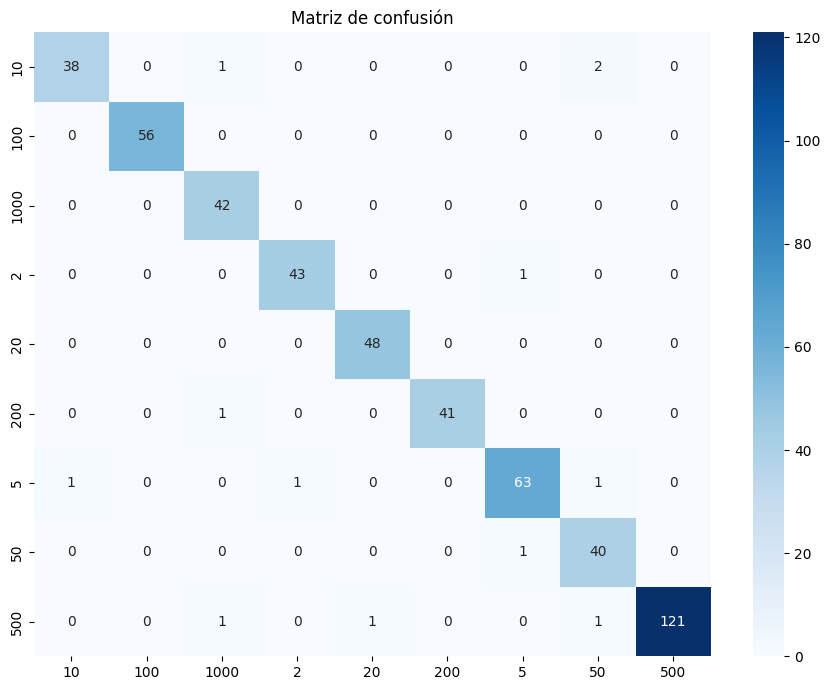

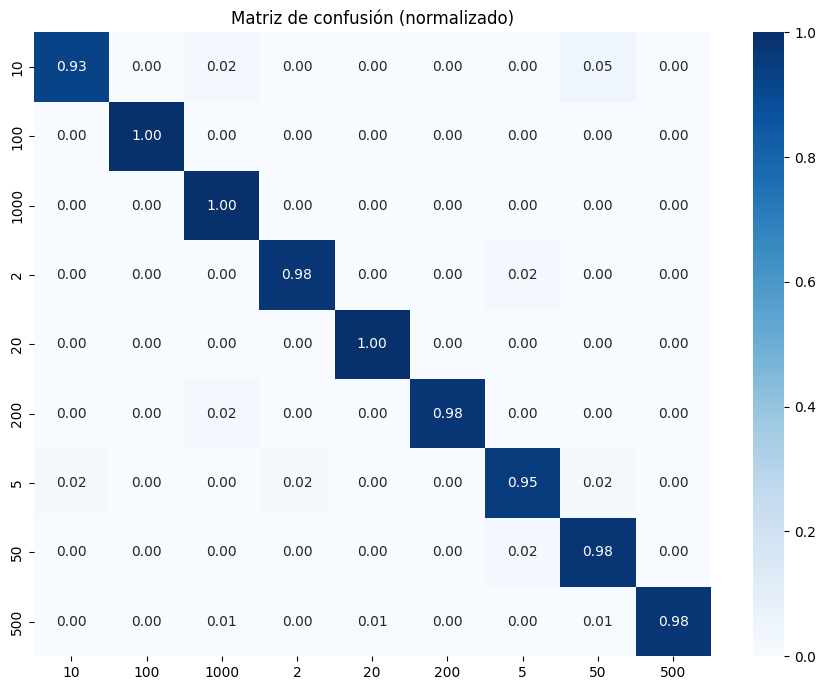

In [67]:
if ensemble_logits is not None and len(model_files) > 1:
    ensemble_probs = ensemble_logits / len(model_files)
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    cm_ens = confusion_matrix(y_test, ensemble_preds)
    print("\n=== Reporte de clasificacion ===\n")
    print(classification_report(y_test, ensemble_preds, target_names=class_names, digits=4))
else:
    ensemble_probs = None
    cm_ens = None

# ----- helper function for plotting CM -----
def plot_cm(cm, labels, title="Matriz de confusión", normalize=False):
    plt.figure(figsize=(9,7))
    if normalize:
        cmn = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
        sns.heatmap(cmn, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="Blues")
        plt.title(title + " (normalizado)")
    else:
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Show confusion matrix for last model and for ensemble
if cm_ens is not None:
    plot_cm(cm_ens, class_names, title="Matriz de confusión", normalize=False)
    plot_cm(cm_ens, class_names, title="Matriz de confusión", normalize=True)
else:
    last_cm = all_cms[-1][1]
    plot_cm(last_cm, class_names, title=f"{model_files[-1]} Matriz de confusión", normalize=False)
    plot_cm(last_cm, class_names, title=f"{model_files[-1]} Matriz de confusión", normalize=True)

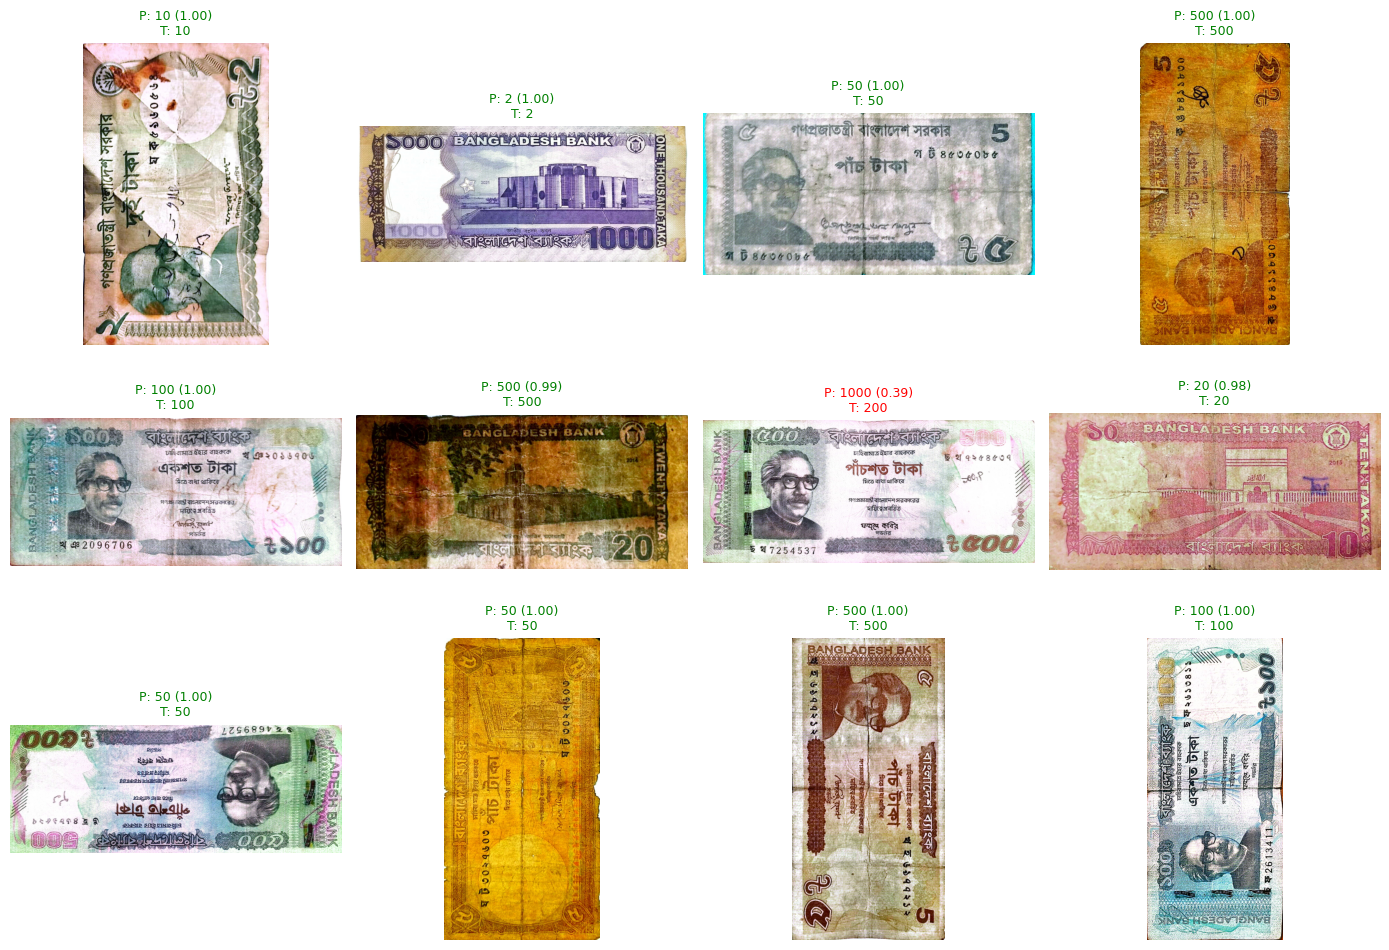

In [57]:
def show_mosaic(file_paths, y_true, pred_labels, probs, class_names, n=12, seed=43):
    import random
    random.seed(seed)
    idxs = random.sample(range(len(file_paths)), min(n, len(file_paths)))
    cols = 4
    rows = (len(idxs) + cols - 1)//cols
    plt.figure(figsize=(cols*3.5, rows*3.2))
    for i, idx in enumerate(idxs):
        p = file_paths[idx]
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        pred = int(pred_labels[idx])
        true = int(y_true[idx])
        prob = float(np.max(probs[idx]))
        title = f"P: {class_names[pred]} ({prob:.2f})\nT: {class_names[true]}"
        color = "green" if pred == true else "red"
        plt.title(title, fontsize=9, color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


if ensemble_probs is not None:
    show_probs = ensemble_probs
    show_preds = np.argmax(show_probs, axis=1)
else:
    show_probs = probs
    show_preds = preds

show_mosaic(test_file_paths, y_pred, show_preds, show_probs, class_names, n=12)